해당 파일은 **랜덤한 k개 클래스의 임베딩 벡터**를 시각화해주는 코드입니다.<br/>`embedding > visualize_actor_embedding.ipynb`와의 차이점은<br/>해당 파일에서는 model pth파일 경로를 직접 설정하여 모델을 불러올 수 있다는 점입니다.<br/><br/>사용자가 변수값을 입력해줘야 하는 부분은 **0. 변수설정**입니다.

In [191]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import random

import matplotlib
import matplotlib.pyplot as plt
import cv2

from sklearn.manifold import TSNE


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### 0. 변수설정

In [192]:
# workers: num_workers 파라미터값 지정
workers = 0 if os.name == 'nt' else 4

# data_path: 클래스들(연예인 혹은 캐릭터)을 포함하는 상위폴더
data_path = "/opt/ml/facenet_pytorch/data/total"

# pretrained_path: 모델 경로
pretrained_path = "/opt/ml/facenet_pytorch/models/trained_model/2021-12-20_14_12_38_18.pth"

# num_classes: load하는 모델의 train시 학습 클래스 개수
num_classes = 5513

# k: k개 클래스 임베딩 벡터를 시각화 할 예정
k = 10

# flag_crop: 시각화하는 폴더의 사진이 crop이 되어있는지 여부
flag_crop = True

#### 1. MTCNN 모듈 및 InceptionResnetV1 모듈 정의

In [193]:
mtcnn = MTCNN(
    image_size=160, margin=80, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [194]:
resnet = InceptionResnetV1(classify=True, num_classes=num_classes).eval().to(device)

In [195]:
resnet.load_state_dict(torch.load(pretrained_path))

<All keys matched successfully>

#### 2. 랜덤한 k개 클래스 선택

In [196]:
# 사진이 없는 경우 해당 폴더는 제외
class_names = []
remove_names = []
for actor_name in os.listdir(data_path):
    file_path = os.path.join(data_path, actor_name)
    if os.path.isdir(file_path):
        if len(os.listdir(file_path)) > 0: # 해당 폴더에 사진이 있는 경우
            class_names.append(actor_name)
        else:
            remove_names.append(actor_name)

print(f'폴더 개수: {len(class_names)}')
print(f'사진이 존재하지 않는 폴더: {len(remove_names)}')

폴더 개수: 1050
사진이 존재하지 않는 폴더: 0


In [197]:
select_names = random.sample(class_names, 10)
print(f'랜덤 10개 클래스:\n{select_names}')

랜덤 10개 클래스:
['서강준', '김옥빈', '699415_1', '하석진', '725586_5', '김다솜', '김재화', '738809_4', '백승희', '서예화']


#### 3. Crop을 위한 custom Dataset정의 및 Data로드

In [198]:
class CustomImageDataset(Dataset):
    def __init__(self, data_path, select_names):
        self.imgs, self.labels, self.paths, self.idx_to_class = self.make_dataset(data_path, select_names)
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        label = self.labels[idx]
        path = self.paths[idx]
        return img, label, path

    def make_dataset(self, data_path, select_names):
        imgs = []
        labels = []
        paths = []
        idx_to_class = {key:name for key, name in enumerate(select_names)}
        for key, name in idx_to_class.items():
            actor_path = os.path.join(data_path, name)
            for img_name in os.listdir(actor_path):
                # img의 차원이 3이 아니거나, 채널의 개수가 3이 아닌 경우 제외
                img_path = os.path.join(actor_path, img_name)
                img = cv2.imread(img_path)
                if type(img) == np.ndarray and len(img.shape) == 3 and img.shape[2] == 3:
                    img = cv2.resize(img, (160, 160))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    imgs.append(img)
                    labels.append(key)
                    paths.append(img_path)

        return imgs, labels, paths, idx_to_class

In [199]:
dataset = CustomImageDataset(data_path, select_names)

In [200]:
print(f'이미지 개수: {len(dataset.imgs)}')
print(f'dataset.idx_to_class: {dataset.idx_to_class}')

이미지 개수: 291
dataset.idx_to_class: {0: '서강준', 1: '김옥빈', 2: '699415_1', 3: '하석진', 4: '725586_5', 5: '김다솜', 6: '김재화', 7: '738809_4', 8: '백승희', 9: '서예화'}


In [201]:
def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

#### 4. Crop 수행

In [202]:
aligned = []
names = []
img_names = []

if flag_crop:
    for x, y, path in loader:
        x_aligned = ((torch.tensor(x).permute(2, 0, 1) - 127.5) / 128)
        
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])
        img_names.append(path.split('/')[-1])
else:
    for x, y, path in loader:
        x_aligned, prob = mtcnn(x, return_prob=True)
        
        if x_aligned is not None:
            aligned.append(x_aligned)
            names.append(dataset.idx_to_class[y])
            img_names.append(path.split('/')[-1])

#### 5. Embedding vector 계산을 위한 Dataset정의 및 데이터로드

In [203]:
class EmbeddingDataset(Dataset):
    def __init__(self, aligned: list, names: list, img_names: list):
        aligned_torch = torch.stack(aligned)
        self.aligned_torch = aligned_torch
        self.names = names
        self.img_names = img_names

    def __len__(self):
        return len(self.aligned_torch)

    def __getitem__(self, idx):
        return self.aligned_torch[idx], self.names[idx], self.img_names[idx]

In [204]:
aligned_dataset = EmbeddingDataset(aligned, names, img_names)
alinged_loader = DataLoader(aligned_dataset, num_workers=workers, batch_size=1)

#### 6. InceptionResnetV1 수행

In [205]:
embeddings = []
for x in alinged_loader:
    y = resnet(x[0].to(device))
    embeddings.extend(y.detach().cpu().tolist())

#### 7. TSNE로 embedding vector 차원 축소

In [206]:
tsne = TSNE(2, verbose=-1)
tsne_proj = tsne.fit_transform(np.array(embeddings))

/opt/conda/envs/final/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/final/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 291 samples in 0.002s...
[t-SNE] Computed neighbors for 291 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 291 / 291
[t-SNE] Mean sigma: 133.312341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.968208
[t-SNE] KL divergence after 1000 iterations: 0.521860


#### 8. 2차원으로 축소된 embedding vector 시각화

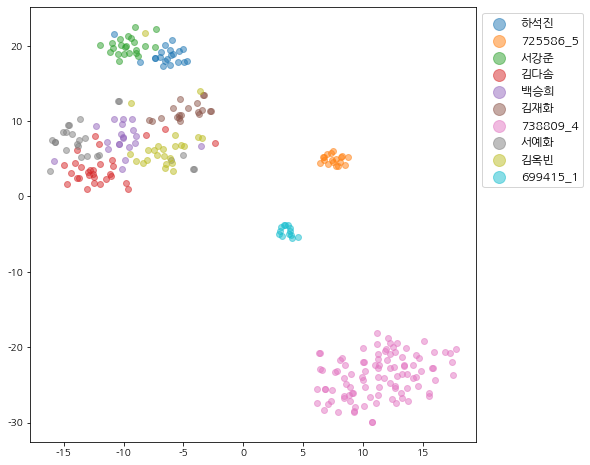

In [207]:
# 범례 한글 깨짐 현상 해결
# https://ehpub.co.kr/47-matplotlib%EC%9D%98-rc%EC%97%90-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8%EB%A5%BC-%EC%84%A4%EC%A0%95%ED%95%A0-%EC%88%98-%EC%9E%88%EC%96%B4%EC%9A%94/
# https://koosco.tistory.com/38
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

num_categories = len(set(names))
cmap = matplotlib.cm.get_cmap('Set1', num_categories)

fig, ax = plt.subplots(figsize=(8,8))
for i,lab in enumerate(set(names)):
    indices = np.array(names)==lab
    ax.scatter(tsne_proj[indices,0], tsne_proj[indices,1], cmap=cmap, label=lab ,alpha=0.5)


ax.legend(fontsize='large', markerscale=2, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()